In [2]:
import pandas as pd
data = pd.read_csv('/content/demand.csv')
data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [3]:
missing_values = data.isnull().sum()
print(missing_values)

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64


In [4]:
median_price_per_sku = data.groupby('sku_id')['total_price'].median()
data['total_price'].fillna(data['sku_id'].map(median_price_per_sku), inplace=True)
data.isnull().sum()

/tmp/ipython-input-4032637318.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_price'].fillna(data['sku_id'].map(median_price_per_sku), inplace=True)


,0
record_ID,0
week,0
store_id,0
sku_id,0
total_price,0
base_price,0
is_featured_sku,0
is_display_sku,0
units_sold,0


In [8]:
data['week'] = pd.to_datetime(data['week'],format='%d/%m/%y')
weekly_data = data.groupby('week')['units_sold'].sum().reset_index()
weekly_data.head()

,week,units_sold
0,2011-01-17,60029
1,2011-01-24,56752
2,2011-01-31,51467
3,2011-02-07,54656
4,2011-02-14,109207


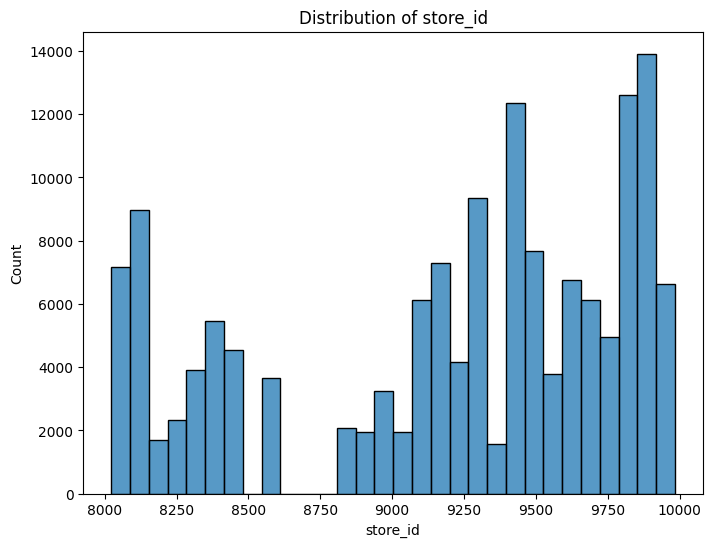

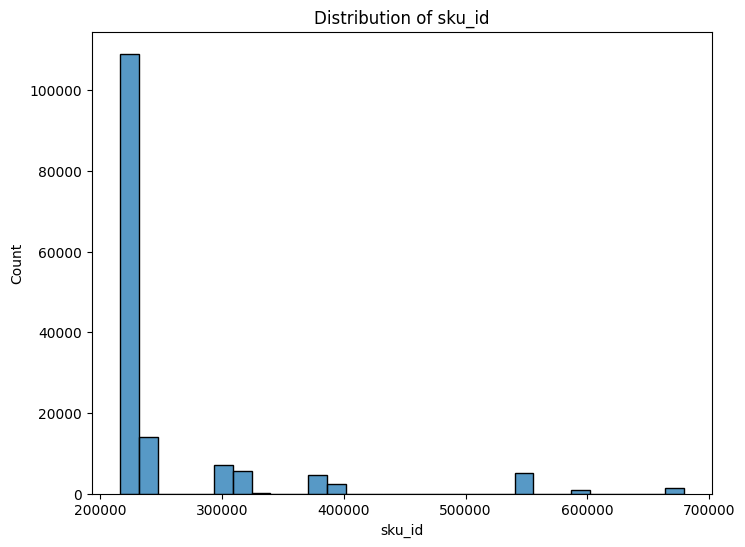

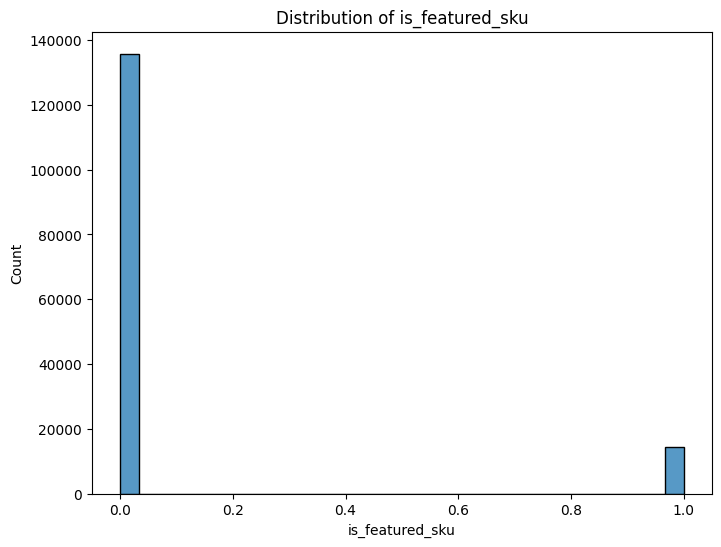

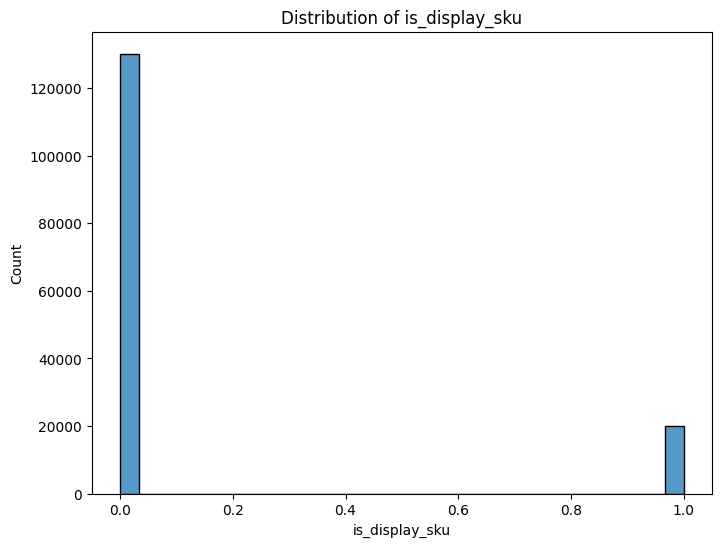

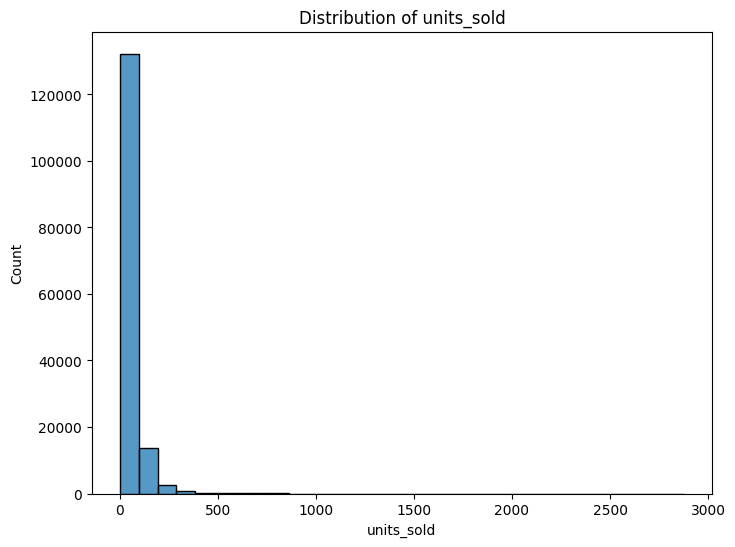

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
categorical_cols = ['store_id','sku_id','is_featured_sku','is_display_sku','units_sold']
for col in categorical_cols:
  plt.figure(figsize=(8,6))
  sns.histplot(data[col], bins=30)
  plt.title(f'Distribution of {col}')
  plt.show()


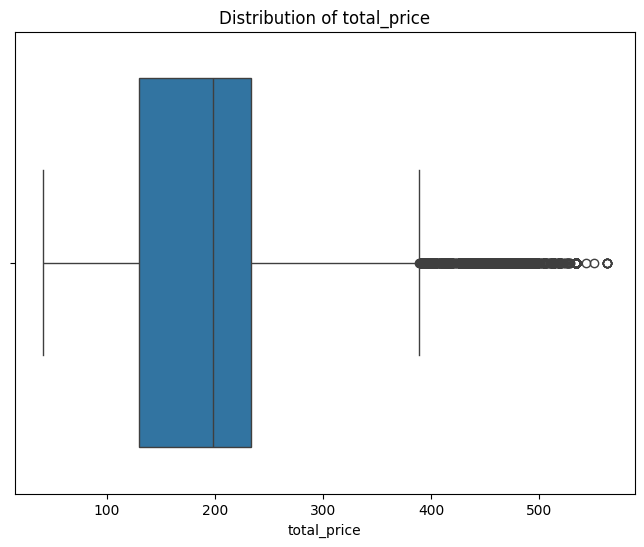

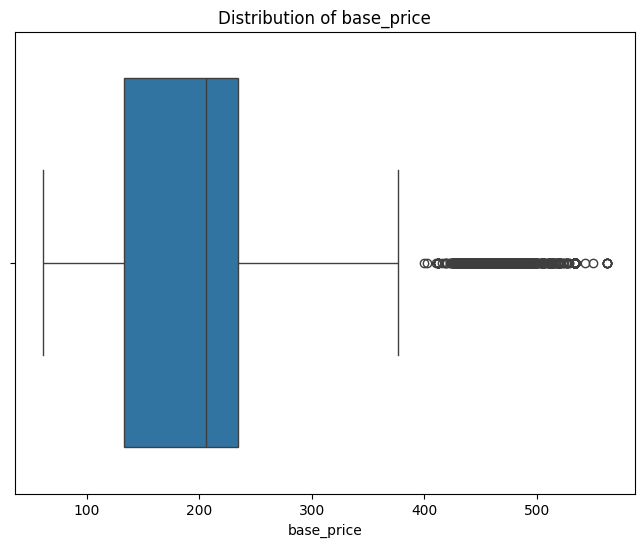

In [15]:
numerical_cols = ['total_price','base_price']
for col in numerical_cols:
  plt.figure(figsize=(8,6))
  sns.boxplot(x=data[col])
  plt.title(f'Distribution of {col}')
  plt.show()

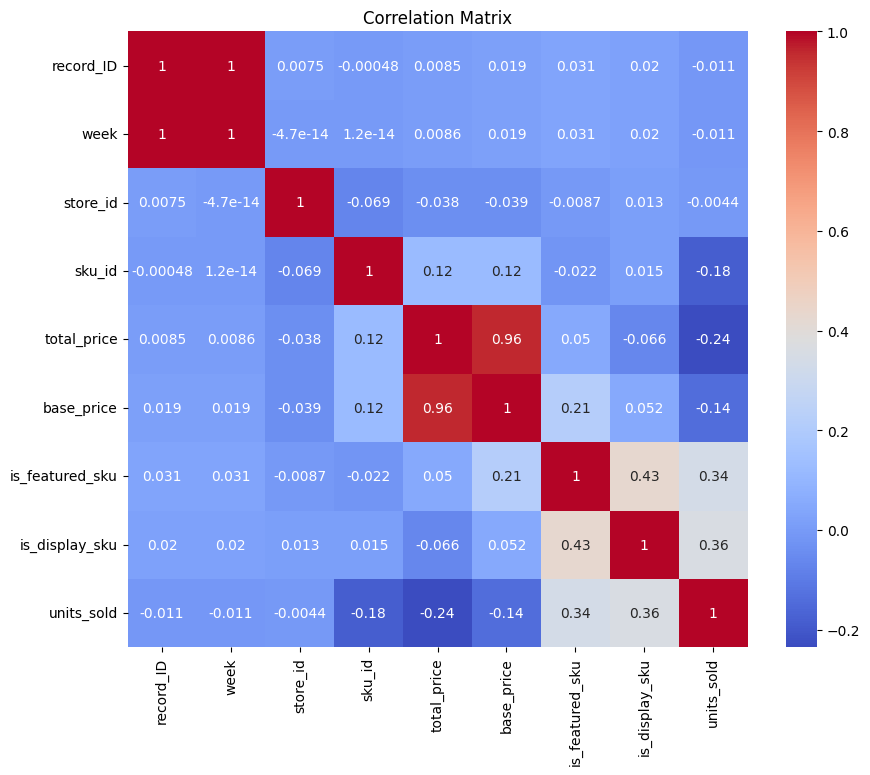

In [16]:
correlation = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Observations:

store_id : contain data from multiple stores but not enough for observations

sku_id : like store_id,data but not enough

is_featured_sku and is_display_sku : both are sku are relatively(moderately) correlated.

units_sold : right_skewed,most are low but in some weeks,many are sold

total_price and base_price : some outliers(especially in total price) may be special sale or expensive



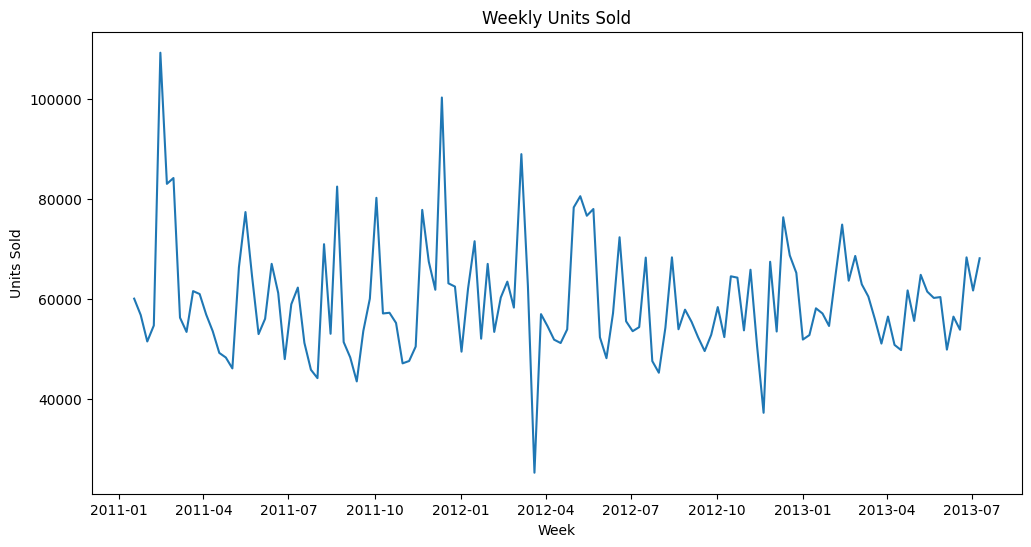

In [17]:
#time series
plt.figure(figsize=(12,6))
sns.lineplot(x='week',y='units_sold',data=weekly_data)
plt.title('Weekly Units Sold')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.show()


irregular pattern.see periodic spikes,no clear increase or decrease trend


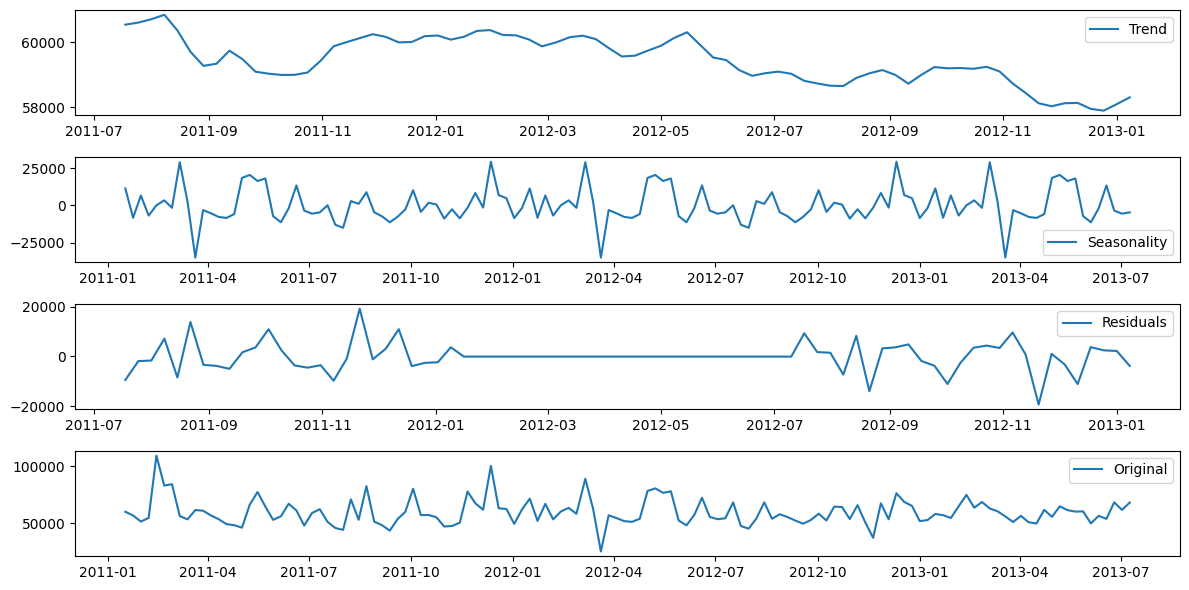

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_data.set_index('week',inplace=True)
decomposition = seasonal_decompose(weekly_data['units_sold'],model='additive',period=52)
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(decomposition.trend,label='Trend')
plt.legend(loc='best')
#seasonality
plt.subplot(412)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
#residuals
plt.subplot(413)
plt.plot(decomposition.resid,label='Residuals')
plt.legend(loc='best')
#original
plt.subplot(414)
plt.plot(weekly_data,label='Original')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

insights from decompositon:

trend : relatively stable,no significant increase or decrease

seasonality : a clear pattern annually.When specific times, sales be higher or lower

residuals : it is normal

In [19]:
#check voltality
weekly_data['units_sold_pct_change'] = weekly_data['units_sold'].pct_change()
volatility = weekly_data['units_sold_pct_change'].std()
print(f'Volatility of units sold: {volatility}')

Volatility of units sold: 0.2605985501452376


fair volatility - can forecast

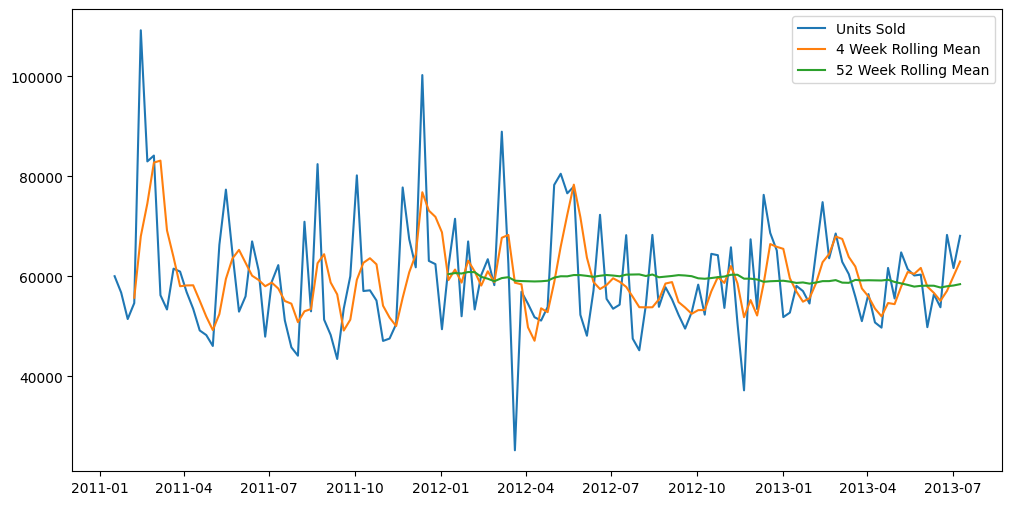

In [20]:
weekly_data['4_week_rolling_mean'] = weekly_data['units_sold'].rolling(window=4).mean()
weekly_data['52_week_rolling_mean'] = weekly_data['units_sold'].rolling(window=52).mean()
plt.figure(figsize=(12,6))
plt.plot(weekly_data.index,weekly_data['units_sold'],label='Units Sold')
plt.plot(weekly_data.index,weekly_data['4_week_rolling_mean'],label='4 Week Rolling Mean')
plt.plot(weekly_data.index,weekly_data['52_week_rolling_mean'],label='52 Week Rolling Mean')
plt.legend()
plt.show()

52 week give clearer view than 4 week

stable pattern



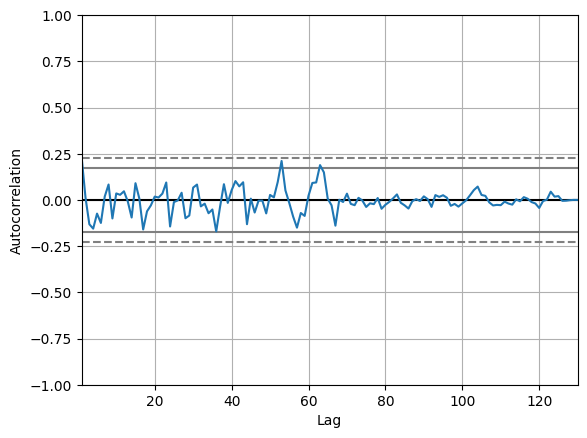

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(weekly_data['units_sold'])
plt.show()

it shows presence of seasonality in data

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from math import sqrt
train_data = weekly_data['units_sold'][:int(0.8*len(weekly_data))]
test_data = weekly_data['units_sold'][int(0.8*len(weekly_data)):]
model = ExponentialSmoothing(train_data,seasonal='add',seasonal_periods=52).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(start=len(train_data), end=len(weekly_data)-1)
rmse = sqrt(mean_squared_error(test_data, predictions))
print(f'RMSE: {rmse}')

RMSE: 9099.893108581457


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
# Resample the data to a weekly frequency
weekly_data_resampled = weekly_data['units_sold'].resample('W').sum()

# Split the resampled data into train and test sets
train_data_resampled = weekly_data_resampled[:int(0.8*(len(weekly_data_resampled)))]
test_data_resampled = weekly_data_resampled[int(0.8*(len(weekly_data_resampled))):]

# Fit the model to the resampled data
model_resampled = ExponentialSmoothing(train_data_resampled, seasonal='add', seasonal_periods=52).fit()

# Generate predictions on the resampled data
predictions_resampled = model_resampled.predict(start=test_data_resampled.index[0], end=test_data_resampled.index[-1])

# Calculate the root mean squared error (RMSE) on the resampled data
rmse_resampled = sqrt(mean_squared_error(test_data_resampled, predictions_resampled))
rmse_resampled

9099.893108581457

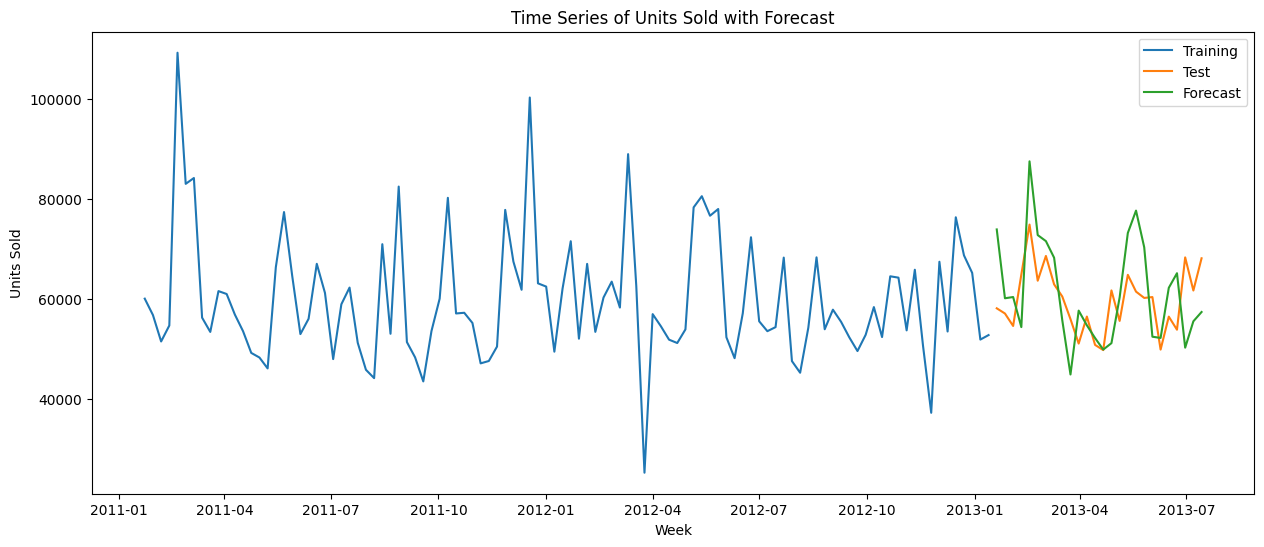

In [31]:
plt.figure(figsize=(15, 6))

plt.plot(train_data_resampled, label='Training')
plt.plot(test_data_resampled, label='Test')
plt.plot(predictions_resampled, label='Forecast')

plt.title('Time Series of Units Sold with Forecast')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()

plt.show()

High RMSE for Holt but to be clear

In [37]:
arima_model = ARIMA(train_data_resampled, order=(1, 0, 0))
arima_predictions = arima_model.fit().predict(start=test_data_resampled.index[0], end=test_data_resampled.index[-1])
arima_rmse  = sqrt(mean_squared_error(test_data_resampled, arima_predictions))
arima_rmse

6235.736166484375

In [41]:
prophet_data = weekly_data.reset_index()
prophet_data.columns = ['ds', 'y']

# Split the data into train and test sets
train_data_prophet = prophet_data[:int(0.8*(len(prophet_data)))]
test_data_prophet = prophet_data[int(0.8*(len(prophet_data))):]

# Fit a Prophet model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(train_data_prophet)

# Generate predictions from the Prophet model
prophet_future = prophet_model.make_future_dataframe(periods=len(test_data_prophet))
prophet_predictions = prophet_model.predict(prophet_future)

# Calculate the RMSE for each model
hw_rmse = sqrt(mean_squared_error(test_data, hw_predictions))
arima_rmse = sqrt(mean_squared_error(test_data, arima_predictions))
prophet_rmse = sqrt(mean_squared_error(test_data_prophet['y'], prophet_predictions['yhat'][-len(test_data_prophet):]))

print("Holt-Winters RMSE:", hw_rmse)
print("ARIMA RMSE:", arima_rmse)
print("Prophet RMSE:", prophet_rmse)
best_model = min(hw_rmse, arima_rmse, prophet_rmse)
print("Best Model RMSE:", best_model)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Holt-Winters RMSE: 9099.893108581457
ARIMA RMSE: 6235.736166484375
Prophet RMSE: 7710.308484078297
Best Model RMSE: 6235.736166484375


In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Fit a Prophet model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(train_data_prophet)

# Generate predictions from the Prophet model for the test period
prophet_future = prophet_model.make_future_dataframe(periods=len(test_data_prophet))
prophet_predictions = prophet_model.predict(prophet_future)

# Extract the predicted and actual values
prophet_predicted = prophet_predictions[-len(test_data_prophet):]['yhat']
prophet_actual = test_data_prophet['y']

# Calculate the RMSE
prophet_rmse = np.sqrt(mean_squared_error(prophet_actual, prophet_predicted))
print('Prophet RMSE:', prophet_rmse)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet RMSE: 7710.308484078297


In [49]:
import plotly.graph_objs as go
import plotly.offline as py

final_df = pd.DataFrame(arima_predictions) # This will have a column named 'predicted_mean'

# Plot training data (actuals)
train_chart = go.Scatter(x=train_data_resampled.index, y=train_data_resampled, mode='lines', name='Training Actuals')

# Plot test data (actuals)
actual_test_chart = go.Scatter(x=test_data_resampled.index, y=test_data_resampled, mode='lines', name='Test Actuals')

# Plot ARIMA predictions (using the correct column name 'predicted_mean')
predict_chart = go.Scatter(x=final_df.index, y=final_df["predicted_mean"], mode='lines', name='ARIMA Predicted')

# Combine all charts
py.plot([train_chart, actual_test_chart, predict_chart])

'temp-plot.html'

In [50]:
final_df = pd.DataFrame(prophet_predictions)
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(y=train_data_prophet["y"], name= 'Actual')
predict_chart = go.Scatter(y=final_df["yhat"], name= 'Predicted')
predict_chart_upper = go.Scatter(y=final_df["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'

i make predictions for both ARIMA and facebook prophet

ARIMA for low rmse

prophet is for always i use

prophet is easier to understand
